# Speckle noise in Sentinel-1


Speckle noise is multiplicative 

Y=NX

and

p(N)= $\frac{L^{L} N^{L-1}e^{-L N}}{\Gamma(L)}$

where L is number of looks


Equivalent number of looks can be estimated as $mean^2/std^2$

In [1]:
%pylab notebook
import numpy as np
import datacube

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib import pyplot as plt

<IPython.core.display.Javascript object>


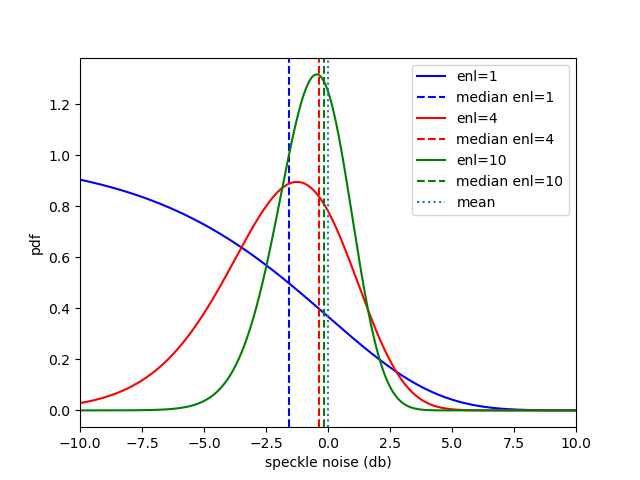

1 0.999046063423235 0.6930000000000001
4 0.9999999999991904 0.918
10 1.0 0.967


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


In [53]:
from scipy.stats import gamma, norm
import numpy as np
from matplotlib import pyplot as plt

plt.figure()
x = np.arange(0, 10, 0.001)
for enl,color in zip([1,4,10],['b','r','g']):
    rv = gamma(enl, scale =1./enl)
    y = rv.pdf(x)
    avg = (x*y).sum()/y.sum()
    med = x[y.cumsum()>=(y.sum()/2.)][0]
    print(enl, avg, med)
    
    plt.plot(10*np.log10(x), y, label='enl=%d'%enl, color=color)
    plt.axvline(10*np.log10(med), linestyle='--', color=color, label='median enl=%d'%enl)

#rv = norm(0,0.5)
#plt.plot(10*np.log10(x), 5*rv.pdf(10*np.log10(x)), label='normal', color='black')
#plt.axvline(1., linestyle=':', label='mean')
#plt.xlim((0,3))

plt.axvline(0., linestyle=':', label='mean')
plt.xlim((-10,10))
plt.legend()
plt.xlabel('speckle noise (db)')
plt.ylabel('pdf')
plt.savefig('gamma_enl_db.png')


<IPython.core.display.Javascript object>


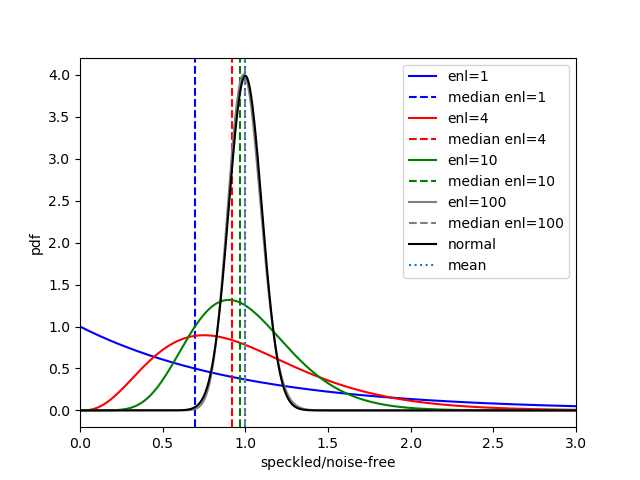

1 0.999046063423235 0.6930000000000001
4 0.9999999999991904 0.918
10 1.0 0.967
100 1.0 0.997


Text(0, 0.5, 'pdf')

In [52]:
plt.figure()
x = np.arange(0, 10, 0.001)
for enl,color in zip([1,4,10,100],['b','r','g','gray']):
    rv = gamma(enl, scale =1./enl)
    y = rv.pdf(x)
    avg = (x*y).sum()/y.sum()
    med = x[y.cumsum()>=(y.sum()/2.)][0]
    print(enl, avg, med)
    plt.plot(x, rv.pdf(x), label='enl=%d'%enl, color=color)
    plt.axvline(med, linestyle='--', color=color, label='median enl=%d'%enl)

rv = norm(1,0.1)
plt.plot(x, rv.pdf(x), label='normal', color='black')

plt.axvline(1., linestyle=':', label='mean')

plt.xlim((0,3))
plt.legend()
plt.xlabel('speckled/noise-free')
plt.ylabel('pdf')


In [22]:
def onclick(event):
    global pixelx, pixely, datax, datay
    datax, datay = event.xdata, event.ydata
    pixelx, pixely = int(event.x), int(event.y)
    w.value = 'pixelx : {}, pixely : {}, datax : {}, datay : {}'.format(pixelx, pixely, datax, datay)

In [4]:
dc = datacube.Datacube(config='radar.conf')

In [5]:
prod_dc = datacube.Datacube()

## Forest area with fully developed gamma distributed speckle

In [6]:
# sunshine coast for uniform forest 
# speckle distribution
query = {
'y': (-26.74, -26.70), 
'x': (152.56, 152.60),
'time':('2015-01-01','2020-01-01'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (25, -25)
}

In [7]:
radar = dc.load(product='s1_gamma0_scene_v6', group_by='solar_day', **query)

In [8]:
gm = prod_dc.load(product ='ls8_nbart_geomedian_annual', 
                   time=('2017-01-01','2017-02-01'),
                   lat=query['y'], lon=query['x'], output_crs = query['output_crs'],
                   resolution=query['resolution'])

In [9]:
mean = radar[['vv','vh']].mean(dim='time')
mean['vh_over_vv']=mean.vh/mean.vv

In [10]:
mean['vv']=mean.vv/10.

<IPython.core.display.Javascript object>


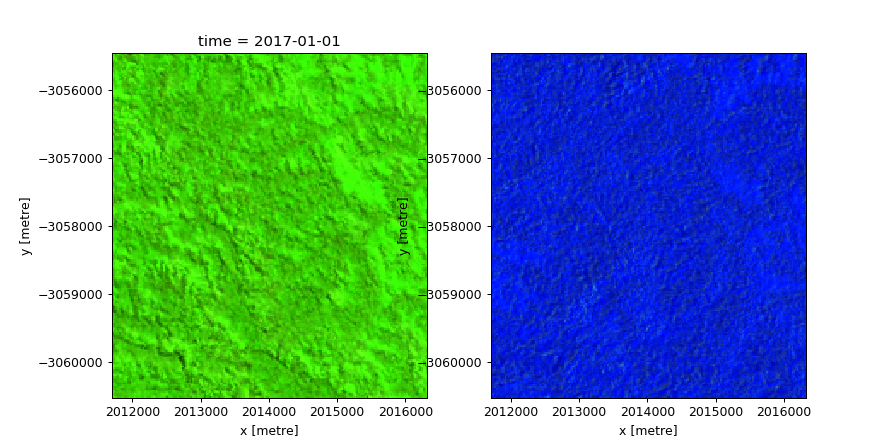

HTML(value='Click on the pixel to view its time series below')

In [13]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
gm.isel(time=0)[['swir1','nir','green']].to_array().plot.imshow(robust=True,ax=ax[0])
mean.to_array().plot.imshow(robust=True,ax=ax[1])

import ipywidgets as widgets
w = widgets.HTML("Click on the pixel to view its time series below")

cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

<IPython.core.display.Javascript object>


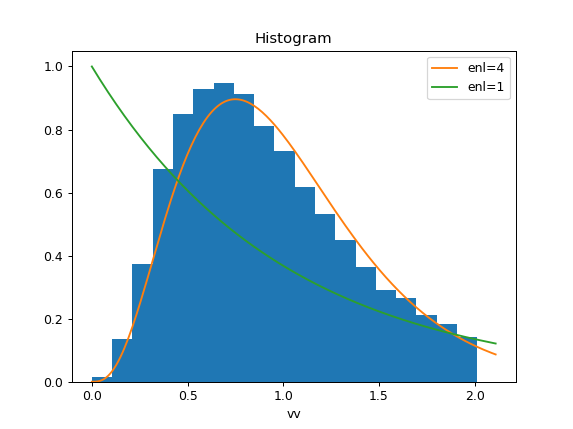

In [18]:
w=10

fig=plt.figure()
pickx, picky = np.abs(radar.x-datax).argmin().values, np.abs(radar.y-datay).argmin().values
vv = radar.isel(x=slice(pickx-w,pickx+w), y=slice(picky-w,picky+w)).vv

#vv = radar.isel(time=0).vv
vv = vv/vv.mean()
#vv = vv/vv.median()
vv.plot.hist(bins=np.arange(0,np.percentile(vv,95),np.percentile(vv,95)/20.),normed=True);

from scipy.stats import gamma
enl=4
x = np.arange(0,np.percentile(vv,95),np.percentile(vv,95)/200.)
rv = gamma(enl, scale=1./enl)
plt.plot(x, rv.pdf(x), label='enl=%d'%enl)
enl=1
rv = gamma(enl, scale=1./enl)
plt.plot(x, rv.pdf(x), label='enl=%d'%enl)
plt.legend()

In [19]:
vv = radar.isel(x=slice(pickx-w,pickx+w), y=slice(picky-w,picky+w)).vv
(vv.mean()/vv.std())**2

<xarray.DataArray 'vv' ()>
array(2.911153)

## Urban area with skewed noise distribution

In [20]:
# Sydney
query = {
'y': (-33.875, -33.865), 
'x': (151.21, 151.22),
'time':('2015-01-01','2019-01-01'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (25, -25)
}
radar = dc.load(product='s1_gamma0_scene_v6', group_by='solar_day', **query)
mean = radar[['vv','vh']].mean(dim='time')
mean['vh_over_vv']=mean.vh/mean.vv
mean['vv']=mean.vv/10.
gm = prod_dc.load(product ='ls8_nbart_geomedian_annual', 
                   time=('2017-01-01','2017-02-01'),
                   lat=query['y'], lon=query['x'], output_crs = query['output_crs'],
                   resolution=query['resolution'])

<IPython.core.display.Javascript object>


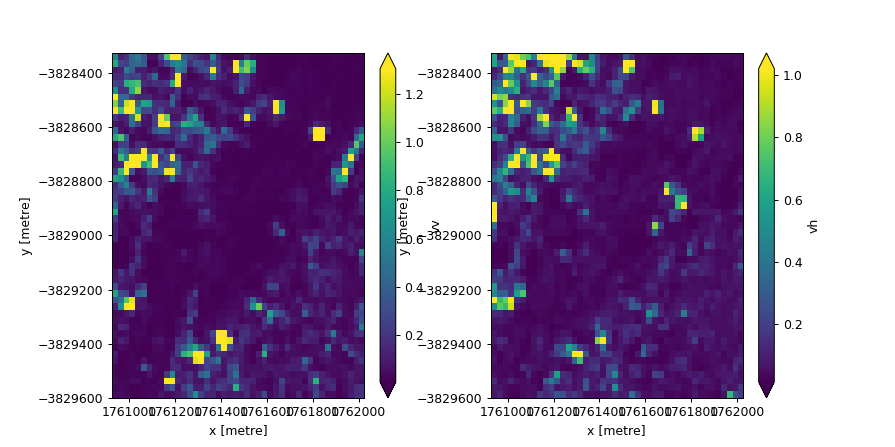

In [21]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
mean.vv.plot.imshow(robust=True,ax=ax[0])
mean.vh.plot.imshow(robust=True,ax=ax[1])

<IPython.core.display.Javascript object>


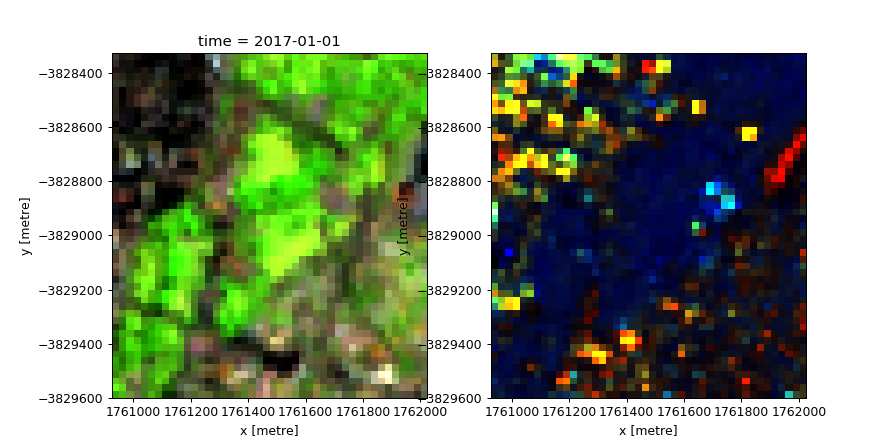

HTML(value='Click on the pixel to view its time series below')

In [22]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
gm.isel(time=0)[['swir1','nir','green']].to_array().plot.imshow(robust=True,ax=ax[0])
mean.to_array().plot.imshow(robust=True,ax=ax[1])

import ipywidgets as widgets
w = widgets.HTML("Click on the pixel to view its time series below")

cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

<IPython.core.display.Javascript object>


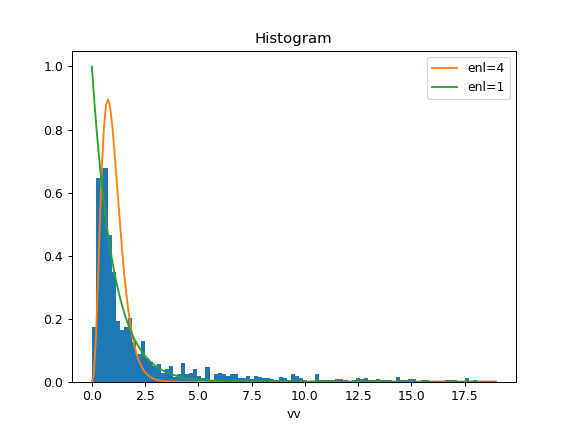

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/plot/plot.py:382: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  primitive = ax.hist(no_nan, **kwargs)


In [23]:
w=2

fig=plt.figure()
pickx, picky = np.abs(radar.x-datax).argmin().values, np.abs(radar.y-datay).argmin().values
vv = radar.isel(x=slice(pickx-w,pickx+w), y=slice(picky-w,picky+w)).vv

#vv = radar.isel(time=0).vv
#vv = vv/vv.mean()
vv = vv/vv.median()
bins = np.arange(0,np.percentile(vv,95),np.percentile(vv,95)/100.)
vv.plot.hist(bins=bins,normed=True);

from scipy.stats import gamma
enl=4
x = np.arange(0,np.percentile(vv,95),np.percentile(vv,95)/200.)
rv = gamma(enl, scale=1./enl)
plt.plot(x, rv.pdf(x), label='enl=%d'%enl)
enl=1
rv = gamma(enl, scale=1./enl)
plt.plot(x, rv.pdf(x), label='enl=%d'%enl)
plt.legend()

<IPython.core.display.Javascript object>


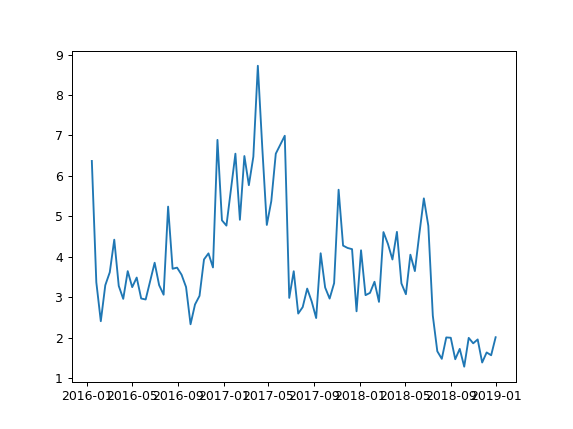

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/groupby.py:713: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


In [24]:
fig=plt.figure()

plt.plot(vv.time.values,vv.groupby('time').mean().values);

In [25]:
vv = radar.isel(x=slice(pickx-w,pickx+w), y=slice(picky-w,picky+w)).vv
(vv.mean()/vv.std())**2

<xarray.DataArray 'vv' ()>
array(0.212949)

<IPython.core.display.Javascript object>


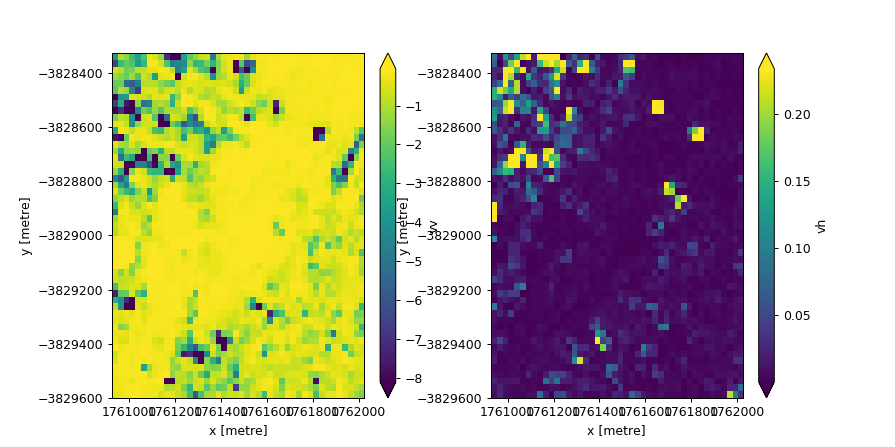

In [26]:
median = radar.median(dim='time')
fig, ax = plt.subplots(1,2,figsize=(10,5))
(mean-median).vv.plot.imshow(robust=True,ax=ax[0])
(mean-median).vh.plot.imshow(robust=True,ax=ax[1])
